In [47]:
import pandas as pd
import numpy as np
import itertools as it
rng = np.random.default_rng(42)
import matplotlib.pyplot as plt 
import pickle

Data:

In [48]:
n_items = 20
df = pd.read_csv(f"data/card_game_test_data/test_data_n20_exp5_float.csv")

items_df_visual = pd.DataFrame()
for trial in range(len(df)):
    trial_data = []
    for item in range(1, n_items+1): 
        row = {
            'Science': df[f'value1_item_{item}'][trial],
            'Culture': df[f'value2_item_{item}'][trial],
            'Govern': df[f'value3_item_{item}'][trial],
            'Money': df[f'weight1_item_{item}'][trial],
            'Space': df[f'weight2_item_{item}'][trial],
            'capacity1': df['capacity1'][trial],
            'capacity2': df['capacity2'][trial],
        }
        trial_data.append(row)
    items_df_visual = pd.concat([items_df_visual, pd.DataFrame(trial_data)], ignore_index=True) ## create a new sequential index

test_trial = items_df_visual.iloc[:n_items,:]

In [49]:
test_trial

,Science,Culture,Govern,Money,Space,capacity1,capacity2
0,2.1,0.7,2.2,5.9,2.8,14.8,13.3
1,2.6,1.5,1.5,0.9,1.9,14.8,13.3
2,1.0,1.6,2.3,0.5,1.3,14.8,13.3
3,5.1,4.7,3.7,2.1,0.9,14.8,13.3
4,0.5,1.8,2.7,1.7,3.3,14.8,13.3
5,0.0,2.1,3.6,0.2,2.6,14.8,13.3
6,2.7,2.5,3.1,4.6,2.6,14.8,13.3
7,0.2,3.5,5.7,0.5,1.0,14.8,13.3
8,0.3,1.6,2.5,1.5,3.8,14.8,13.3
9,1.4,1.6,1.3,0.3,2.1,14.8,13.3


Exact Pareto optimal solutions:

In [50]:
n_selected = 5
objectives = []
solutions = []

for combo in it.combinations(range(n_items), n_selected):
    solution = test_trial.iloc[list(combo)]

    # test if the solution exceeds capacity
    if np.abs(solution["Money"].sum()) > np.abs(solution["capacity1"].iloc[0]) or \
          np.abs(solution["Space"].sum()) > np.abs(solution["capacity2"].iloc[0]):
        continue

    # computes objective values
    objective = [
        solution["Science"].sum(),
        solution["Culture"].sum(),
        solution["Govern"].sum()
    ]
    objectives.append(objective)

    solutions.append(combo)

objectives = np.array(objectives) # shape = (num of solutions, num of objectives)
solutions = np.array(solutions) # shape = (num of solutions, num of items)

In [ ]:
# def non_dominated(objectives):
#     pop_size = np.shape(objectives)[0]
#     non_dominated = np.zeros(pop_size, dtype=bool)
#     for i in range(pop_size):
#         dominated = np.zeros(pop_size, dtype=bool)
#         for j in range(pop_size):
#             # dominated[j]= np.all(objectives[i,:] < objectives[j,:])
#             dominated[j]= np.all(objectives[j,:] >= objectives[i,:]) and \
#                           np.any(objectives[j,:] > objectives[i,:])
#         non_dominated[i] = ~np.any(dominated)
#     return non_dominated

# pareto = non_dominated(objectives)

In [51]:
def non_dominated(objectives):
    n_solutions = objectives.shape[0]
    non_dominated = np.ones(n_solutions, dtype=bool)
    for i in range(n_solutions):
        for j in range(n_solutions):
            if i == j:
                continue

            if np.all(objectives[j, :] >= objectives[i, :]) and \
                np.any(objectives[j, :] > objectives[i, :]):
                non_dominated[i] = False
                break

    return non_dominated

In [52]:
pareto_exact = non_dominated(objectives)

In [53]:
print(solutions[pareto_exact, :].shape)
print(objectives[pareto_exact, :].shape)
print(np.unique(objectives[pareto_exact, :], axis=0).shape)

(41, 5)
(41, 3)
(41, 3)


EDA with elitist nondominated sorting & diversity preservation:

In [17]:
def non_dominated_sort(objectives):
    n_solutions = objectives.shape[0]
    dominated_sets = [[] for _ in range(n_solutions)] # the set of solutions that p dominates
    domination_counts = [0] * n_solutions # the number of solutions that dominate p
    ranks = np.full(n_solutions, -1, dtype=int)           
    fronts = [[]]  

    for p in range(n_solutions):
        for q in range(n_solutions):
            if p == q:
                continue

            if np.all(objectives[p, :] >= objectives[q, :]) and \
                np.any(objectives[p, :] > objectives[q, :]):
                dominated_sets[p].append(q)
            elif np.all(objectives[q, :] >= objectives[p, :]) and \
                np.any(objectives[q, :] > objectives[p, :]):
                domination_counts[p] += 1 
        
        if domination_counts[p] == 0:
            ranks[p] = 0
            fronts[0].append(p)
    
    
    i = 0
    while i < len(fronts) and len(fronts[i]) > 0:
        next_front = []
        for p in fronts[i]:
            for q in dominated_sets[p]: 
                domination_counts[q] -= 1
                if domination_counts[q] == 0:
                    ranks[q] = i + 1
                    next_front.append(q)
        
        if next_front:
            fronts.append(next_front)
        i += 1

    dominated_sets = np.array([np.array(s, dtype=int) for s in dominated_sets], dtype=object)
    domination_counts = np.array(domination_counts, dtype=int)
    ranks = np.array(ranks, dtype=int)
    fronts = np.array([np.array(f, dtype=int) for f in fronts if len(f) > 0], dtype=object)

    return  dominated_sets, domination_counts, ranks, fronts

# dominated_sets, domination_counts, ranks, fronts = non_dominated_sort(objectives)

# with open("non_dominated_sort_results.pkl", "wb") as f:
#     pickle.dump((dominated_sets, domination_counts, ranks, fronts), f)

In [18]:
def assign_crowding_distance(objectives):
    distances = np.zeros(objectives.shape[0],  dtype=float)
    for m in range(np.shape(objectives)[1]):
        objective = objectives[:, m]
        sort_indices = np.argsort(objective)[::-1]
        sorted_objective = objective[sort_indices]
        min = sorted_objective[0]
        max = sorted_objective[-1]

        distances[sort_indices[0]] = np.inf
        distances[sort_indices[-1]] = np.inf
        for i in range(1, np.shape(objectives)[0] - 1):
            distances[sort_indices[i]] += (sorted_objective[i + 1] - sorted_objective[i - 1]) \
            / (max - min)
    return distances

In [19]:
def binary_tournament_selection(population, ranks, distances, rng):
    indices = np.arange(len(population))
    i, j = rng.choice(indices, size=2, replace=False)
    if ranks[i] < ranks[j]:
        return i
    if ranks[j] < ranks[i]:
        return j
    else:
        if distances[i] > distances[j]:
            return i
        else:
            return j

In [ ]:
def evaluatePopulation(population, n_obj):
    objectives = np.zeros((np.shape(population)[0], n_obj))
    for j in range(np.shape(population)[0]):
        solution = population[j, :]
        objectives[j, :] = np.sum(test_trial.iloc[solution, :3].values, axis=0)
    return np.round(objectives, 1)  # if int, no need to round

def samplePopulation(distribution, money_cap, space_cap, pop_size, n_selected):
    pop_count = 0
    population = np.zeros((pop_size, n_selected), dtype=int)
    n_cards = np.size(distribution)

    while pop_count < pop_size:
        sample = rng.choice(n_cards, n_selected, p=distribution, replace=False).astype(int)
        if np.abs(np.sum(test_trial.iloc[sample, 3].values)) <= np.abs(money_cap) and \
            np.abs(np.sum(test_trial.iloc[sample, 4].values)) <= np.abs(space_cap):
            population[pop_count, :] = sample
            pop_count += 1
            
    return population

In [36]:
n_cards = n_items
n_selected = 5
n_obj = 3
money_cap = test_trial["capacity1"].iloc[0]
space_cap = test_trial["capacity2"].iloc[0]
pop_size = 1000
training_size = 5


# intial population
distribution = np.ones(n_cards)/n_cards
population = samplePopulation(distribution, money_cap, space_cap, pop_size, n_selected) 
objectives = evaluatePopulation(np.array(population), n_obj)

_, _, ranks, fronts = non_dominated_sort(objectives)
distances_all_solutions = np.zeros(population.shape[0], dtype=float)
for f in fronts:
    distances = assign_crowding_distance(objectives[f, :])
    distances_all_solutions[f] = distances

select_indices = np.array([], dtype=int)
while len(select_indices) < pop_size:
    indice = binary_tournament_selection(population, ranks, distances_all_solutions, rng)
    select_indices = np.concatenate([select_indices, np.array([indice])])
selected_population = population[select_indices]
selected_objectives = objectives[select_indices]

distribution = np.ones(n_cards)
distribution += np.bincount(selected_population.flatten(), minlength=n_cards)
distribution /= np.sum(distribution)


for j in range(training_size):
    prev_distribution = distribution.copy()
    
    population = samplePopulation(distribution, money_cap, space_cap, pop_size, n_selected)
    objectives = evaluatePopulation(np.array(population), n_obj)
    objectives = np.vstack((selected_objectives, objectives))
    population = np.vstack((selected_population, population))  

    _, _, ranks, fronts = non_dominated_sort(objectives)
    select_indices = np.array([], dtype=int)
    for f in fronts:
        if len(select_indices) + len(f) <= pop_size:
            select_indices = np.concatenate([select_indices, f])
        else:
            remaining_size = pop_size - len(select_indices)
            f_distance = assign_crowding_distance(objectives[f, :])
            sort_indices = np.argsort(f_distance)[::-1]
            remaining = f[sort_indices[:remaining_size]]
            select_indices = np.concatenate([select_indices, remaining])
            break

    selected_population = population[select_indices]
    selected_objectives = objectives[select_indices]

    distribution = np.ones(n_cards)
    distribution += np.bincount(selected_population.flatten(), minlength=n_cards)
    distribution /= np.sum(distribution)

    print(f"Iteration {j+1}")

    if np.allclose(distribution, prev_distribution, atol=1e-6):
        print("Converged")
        break

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5


In [37]:
pareto_indices = non_dominated(selected_objectives)
pareto_population = selected_population[pareto_indices, :]
pareto_objectives = selected_objectives[pareto_indices, :]

In [38]:
pareto_population_sorted = np.sort(pareto_population, axis=1)
pareto_population_unique, unique_indices = np.unique(pareto_population_sorted, axis=0, return_index=True)     
print(pareto_population.shape)
print(pareto_population_unique.shape)    

(337, 5)
(40, 5)


In [40]:
print(pareto_objectives.shape)
print(np.unique(pareto_objectives, axis=0).shape)

(337, 3)
(40, 3)


In [44]:
b = np.unique(pareto_objectives, axis=0)

In [45]:
pareto_objectives_sorted = selected_objectives[unique_indices, :]
a = pareto_objectives_sorted  # compare with exact pareto objectives

In [46]:
# inclusion check
set_a = set(map(tuple, a))
set_b = set(map(tuple, b))

print("A in B:", set_a.issubset(set_b))
print("B in A:", set_b.issubset(set_a))
print("Rows in A not in B:", set_a - set_b)
print("Rows in B not in A:", set_b - set_a)

A in B: True
B in A: True
Rows in A not in B: set()
Rows in B not in A: set()


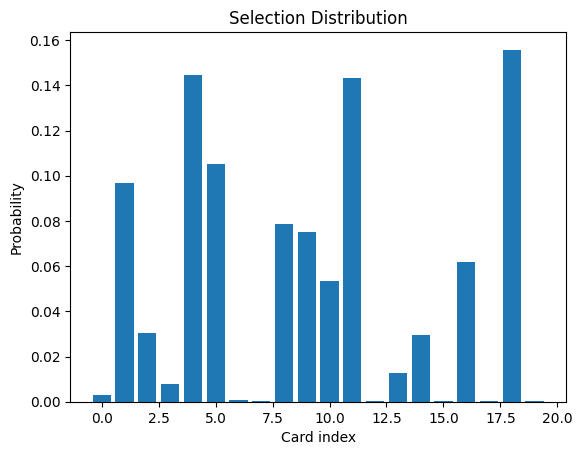

In [18]:
x = np.arange(n_cards)  
plt.bar(x, distribution)
plt.xlabel("Card index")
plt.ylabel("Probability")
plt.title("Selection Distribution")
plt.show()

Original EDA:

In [ ]:
n_cards = n_items
n_selected = 5
n_obj = 3
money_cap = test_trial["capacity1"].iloc[0]
space_cap = test_trial["capacity2"].iloc[0]
pop_size = 1000
training_size = 10


distribution = np.ones(n_cards)/n_cards
population = samplePopulation(distribution, money_cap, space_cap, pop_size, n_selected) 
objectives = evaluatePopulation(np.array(population), n_obj)
pareto = non_dominated(objectives)
pareto_front = objectives[pareto,:]
pareto_solutions = population[pareto,:]

distribution = np.ones(n_cards)
distribution += np.bincount(pareto_solutions.flatten(), minlength=n_cards)
distribution /= np.sum(distribution)

for j in range(training_size):
    prev_distribution = distribution.copy()
    
    population = samplePopulation(distribution, money_cap, space_cap, pop_size, n_selected)
    objectives = evaluatePopulation(np.array(population), n_obj)
    objectives = np.vstack((pareto_front, objectives))
    population = np.vstack((pareto_solutions, population))
    pareto = non_dominated(objectives)
    pareto_front = objectives[pareto,:]
    pareto_solutions = population[pareto,:]

    distribution = np.ones(n_cards)
    distribution += np.bincount(pareto_solutions.flatten(), minlength=n_cards)
    distribution /= np.sum(distribution)

    print(f"Iteration {j+1}")

    if np.allclose(distribution, prev_distribution, atol=1e-6):
        print("Converged")
        break

In [ ]:
pareto_front_original = np.unique(pareto_front, axis=0)
pareto_front_original

In [ ]:
x = np.arange(n_cards)  
plt.bar(x, distribution)
plt.xlabel("Card index")
plt.ylabel("Probability")
plt.title("Selection Distribution")
plt.show()